# MERLIN Anomaly Detection for ECG Seizure Detection

This notebook implements and tests the MERLIN algorithm for detecting seizures in ECG data from the SeizeIT2 dataset.

**Objective**: Apply MERLIN discord discovery to raw ECG signals (256 Hz) to detect seizure events.

**Approach**: Single-run experiment with parameter optimization for window sizes.

## 1. Setup and Imports

In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.signal import butter, filtfilt
import warnings
warnings.filterwarnings('ignore')

# Add seizeit2 classes to path
sys.path.append(os.path.join('..', 'Information', 'Data', 'seizeit2-main'))

from classes.data import Data
from classes.annotation import Annotation

# Try to import MERLIN - install if needed
try:
    from aeon.anomaly_detection import MERLIN
    print("✓ MERLIN successfully imported from aeon")
except ImportError:
    print("❌ MERLIN not available. Install with: pip install aeon[all]")
    print("For now, we'll use a placeholder MERLIN implementation")
    
    # Placeholder MERLIN class for development
    class MERLIN:
        def __init__(self, min_length=256, max_length=2560, max_iterations=500):
            self.min_length = min_length
            self.max_length = max_length
            self.max_iterations = max_iterations
            print(f"Placeholder MERLIN: min_length={min_length}, max_length={max_length}")
        
        def fit_predict(self, X):
            # Placeholder: return random anomalies for testing
            n_samples = len(X)
            anomalies = np.zeros(n_samples, dtype=bool)
            # Add some random anomalies for testing
            n_anomalies = max(1, n_samples // 10000)  # ~0.01% anomalies
            anomaly_indices = np.random.choice(n_samples, n_anomalies, replace=False)
            anomalies[anomaly_indices] = True
            print(f"Placeholder MERLIN detected {n_anomalies} anomalies in {n_samples} samples")
            return anomalies

✓ MERLIN successfully imported from aeon


## 2. Configuration and Constants

In [2]:
# Dataset configuration
DATASET_PATH = "../ds005873-download"
FS = 256  # Sampling frequency (Hz)

# Experiment configuration
EXPERIMENT_DURATION_HOURS = 2  # Use first 2 hours of recording
EXPERIMENT_DURATION_SEC = EXPERIMENT_DURATION_HOURS * 3600

# MERLIN configurations to test
MERLIN_CONFIGS = [
    {"name": "1-10sec", "min_length": 256, "max_length": 2560},  # 1-10 seconds
]

print(f"Experiment Configuration:")
print(f"  Dataset: {DATASET_PATH}")
print(f"  Sampling Rate: {FS} Hz")
print(f"  Duration: {EXPERIMENT_DURATION_HOURS} hours")
print(f"  MERLIN Configs: {len(MERLIN_CONFIGS)}")
for config in MERLIN_CONFIGS:
    min_sec = config['min_length'] / FS
    max_sec = config['max_length'] / FS
    print(f"    {config['name']}: {min_sec:.1f}-{max_sec:.1f}s ({config['min_length']}-{config['max_length']} samples)")

Experiment Configuration:
  Dataset: ../ds005873-download
  Sampling Rate: 256 Hz
  Duration: 2 hours
  MERLIN Configs: 1
    1-10sec: 1.0-10.0s (256-2560 samples)


## 3. ECG Preprocessing Functions

In [3]:
def preprocess_ecg(ecg_signal, fs=256, lowcut=0.5, highcut=40):
    """
    Preprocess raw ECG signal with bandpass filtering
    
    Args:
        ecg_signal (np.array): Raw ECG signal
        fs (int): Sampling frequency
        lowcut (float): Low cutoff frequency (Hz)
        highcut (float): High cutoff frequency (Hz)
    
    Returns:
        np.array: Filtered ECG signal
    """
    # Design bandpass filter
    nyquist = fs / 2
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # 4th order Butterworth bandpass filter
    b, a = butter(4, [low, high], btype='band')
    
    # Apply zero-phase filtering
    filtered_signal = filtfilt(b, a, ecg_signal)
    
    return filtered_signal

def detect_artifacts(ecg_signal, fs=256, artifact_threshold=5.0):
    """
    Simple artifact detection based on amplitude thresholding
    
    Args:
        ecg_signal (np.array): ECG signal
        fs (int): Sampling frequency
        artifact_threshold (float): Threshold in standard deviations
    
    Returns:
        np.array: Boolean mask of artifact samples
    """
    # Calculate rolling statistics (1-second windows)
    window_size = fs
    signal_std = np.std(ecg_signal)
    signal_mean = np.mean(ecg_signal)
    
    # Detect outliers based on amplitude
    threshold = signal_mean + artifact_threshold * signal_std
    artifacts = np.abs(ecg_signal) > threshold
    
    return artifacts

def assess_signal_quality(ecg_signal, fs=256):
    """
    Assess ECG signal quality metrics
    
    Args:
        ecg_signal (np.array): ECG signal
        fs (int): Sampling frequency
    
    Returns:
        dict: Signal quality metrics
    """
    # Basic signal statistics
    signal_stats = {
        'mean': np.mean(ecg_signal),
        'std': np.std(ecg_signal),
        'min': np.min(ecg_signal),
        'max': np.max(ecg_signal),
        'duration_sec': len(ecg_signal) / fs
    }
    
    # Artifact detection
    artifacts = detect_artifacts(ecg_signal, fs)
    artifact_percentage = np.sum(artifacts) / len(ecg_signal) * 100
    
    # Signal quality assessment
    signal_stats['artifact_percentage'] = artifact_percentage
    signal_stats['quality'] = 'good' if artifact_percentage < 5 else 'poor'
    
    return signal_stats

# Test preprocessing functions
print("ECG Preprocessing functions defined:")
print("  ✓ preprocess_ecg() - Bandpass filtering (0.5-40 Hz)")
print("  ✓ detect_artifacts() - Amplitude-based artifact detection")
print("  ✓ assess_signal_quality() - Signal quality metrics")

ECG Preprocessing functions defined:
  ✓ preprocess_ecg() - Bandpass filtering (0.5-40 Hz)
  ✓ detect_artifacts() - Amplitude-based artifact detection
  ✓ assess_signal_quality() - Signal quality metrics


## 4. Data Loading and Patient Selection

In [4]:
def find_patients_with_seizures(data_path, max_patients=10):
    """
    Find patients with seizure annotations for MERLIN experiment
    """
    data_path = Path(data_path)
    patients_with_seizures = []
    
    # Find all patient directories
    patient_dirs = sorted([d for d in data_path.iterdir() if d.is_dir() and d.name.startswith('sub-')])
    
    print(f"Searching for patients with seizures (max {max_patients} patients)...")
    
    for i, patient_dir in enumerate(patient_dirs[:max_patients]):
        patient_id = patient_dir.name
        
        # Look for ECG files
        ecg_path = patient_dir / 'ses-01' / 'ecg'
        if not ecg_path.exists():
            continue
            
        ecg_files = list(ecg_path.glob("*.edf"))
        for ecg_file in ecg_files:
            # Extract run info
            run_info = ecg_file.name.split('_')[-2]
            
            try:
                # Try to load annotations
                recording = [patient_id, run_info]
                annotations = Annotation.loadAnnotation(data_path.as_posix(), recording)
                
                if annotations.events and len(annotations.events) > 0:
                    patients_with_seizures.append((patient_id, run_info, len(annotations.events)))
                    print(f"  ✓ {patient_id} {run_info}: {len(annotations.events)} seizures")
                    
            except Exception as e:
                continue  # No annotations available
    
    return patients_with_seizures

def load_experiment_data(data_path, patient_id, run_id, duration_sec):
    """
    Load ECG data and annotations for experiment
    
    Args:
        data_path (str): Path to dataset
        patient_id (str): Patient ID
        run_id (str): Run ID
        duration_sec (int): Duration to load in seconds
    
    Returns:
        tuple: (ecg_signal, annotations, metadata)
    """
    print(f"\nLoading data for {patient_id} {run_id}...")
    
    # Load ECG data
    recording = [patient_id, run_id]
    data = Data.loadData(data_path, recording, modalities=['ecg'])
    
    if not data.data:
        raise ValueError("No ECG data loaded!")
    
    # Load annotations
    annotations = Annotation.loadAnnotation(data_path, recording)
    
    # Extract ECG signal
    ecg_signal = data.data[0]  # First ECG channel
    fs = data.fs[0]  # Sampling frequency
    channel_name = data.channels[0] if data.channels else 'ECG'
    
    # Limit to experiment duration
    max_samples = int(duration_sec * fs)
    if max_samples < len(ecg_signal):
        ecg_signal = ecg_signal[:max_samples]
        actual_duration = duration_sec
    else:
        actual_duration = len(ecg_signal) / fs
    
    # Filter seizures within experiment duration
    seizures_in_window = []
    if annotations.events:
        for i, (start, end) in enumerate(annotations.events):
            if start < actual_duration:
                seizure_type = annotations.types[i] if i < len(annotations.types) else 'unknown'
                seizures_in_window.append({
                    'start': start,
                    'end': min(end, actual_duration),
                    'duration': min(end, actual_duration) - start,
                    'type': seizure_type
                })
    
    metadata = {
        'patient_id': patient_id,
        'run_id': run_id,
        'fs': fs,
        'channel_name': channel_name,
        'duration_sec': actual_duration,
        'total_samples': len(ecg_signal),
        'seizures_in_window': seizures_in_window,
        'total_seizures': len(annotations.events) if annotations.events else 0
    }
    
    print(f"  Loaded {len(ecg_signal):,} samples ({actual_duration:.1f}s) at {fs} Hz")
    print(f"  Channel: {channel_name}")
    print(f"  Seizures in window: {len(seizures_in_window)} / {metadata['total_seizures']}")
    
    return ecg_signal, annotations, metadata

# Find patients with seizures
seizure_patients = find_patients_with_seizures(DATASET_PATH, max_patients=10)

if seizure_patients:
    print(f"\nFound {len(seizure_patients)} recordings with seizures:")
    for patient_id, run_id, seizure_count in seizure_patients:
        print(f"  {patient_id} {run_id}: {seizure_count} seizures")
else:
    print("\n❌ No patients with seizures found!")
    print("Will use sub-001 for demonstration purposes.")

Searching for patients with seizures (max 10 patients)...
  ✓ sub-001 run-03: 1 seizures
  ✓ sub-001 run-07: 1 seizures
  ✓ sub-001 run-05: 1 seizures
  ✓ sub-001 run-08: 1 seizures
  ✓ sub-002 run-03: 1 seizures
  ✓ sub-002 run-09: 4 seizures
  ✓ sub-002 run-05: 2 seizures
  ✓ sub-002 run-10: 1 seizures
  ✓ sub-002 run-06: 3 seizures
  ✓ sub-002 run-02: 2 seizures
  ✓ sub-002 run-01: 2 seizures
  ✓ sub-003 run-06: 1 seizures
  ✓ sub-004 run-01: 4 seizures
  ✓ sub-005 run-23: 1 seizures
  ✓ sub-005 run-22: 1 seizures
  ✓ sub-006 run-01: 1 seizures
  ✓ sub-007 run-03: 2 seizures
  ✓ sub-008 run-01: 1 seizures
  ✓ sub-008 run-09: 1 seizures
  ✓ sub-009 run-09: 1 seizures
  ✓ sub-010 run-08: 1 seizures

Found 21 recordings with seizures:
  sub-001 run-03: 1 seizures
  sub-001 run-07: 1 seizures
  sub-001 run-05: 1 seizures
  sub-001 run-08: 1 seizures
  sub-002 run-03: 1 seizures
  sub-002 run-09: 4 seizures
  sub-002 run-05: 2 seizures
  sub-002 run-10: 1 seizures
  sub-002 run-06: 3 sei

## 5. Select Patient and Load Data

In [5]:
# Select patient for experiment
if seizure_patients:
    # Use first patient with seizures
    target_patient_id, target_run_id, target_seizure_count = seizure_patients[0]
    print(f"Selected patient: {target_patient_id} {target_run_id} ({target_seizure_count} seizures)")
else:
    # Fallback to sub-001
    target_patient_id = 'sub-001'
    target_run_id = 'run-01'
    target_seizure_count = 0
    print(f"Using fallback patient: {target_patient_id} {target_run_id}")

# Load experiment data
try:
    raw_ecg, annotations, metadata = load_experiment_data(
        DATASET_PATH, 
        target_patient_id, 
        target_run_id, 
        EXPERIMENT_DURATION_SEC
    )
    
    print(f"\n✓ Data loaded successfully")
    print(f"  Patient: {metadata['patient_id']} {metadata['run_id']}")
    print(f"  Duration: {metadata['duration_sec']:.1f} seconds ({metadata['duration_sec']/3600:.1f} hours)")
    print(f"  Samples: {metadata['total_samples']:,} at {metadata['fs']} Hz")
    print(f"  Seizures: {len(metadata['seizures_in_window'])} in experiment window")
    
    if metadata['seizures_in_window']:
        print(f"  Seizure details:")
        for i, seizure in enumerate(metadata['seizures_in_window']):
            print(f"    {i+1}. {seizure['start']:.1f}s - {seizure['end']:.1f}s ({seizure['duration']:.1f}s, {seizure['type']})")
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raw_ecg = None

Selected patient: sub-001 run-03 (1 seizures)

Loading data for sub-001 run-03...
  Loaded 1,843,200 samples (7200.0s) at 256.0 Hz
  Channel: ECG SD
  Seizures in window: 0 / 1

✓ Data loaded successfully
  Patient: sub-001 run-03
  Duration: 7200.0 seconds (2.0 hours)
  Samples: 1,843,200 at 256.0 Hz
  Seizures: 0 in experiment window


## 6. ECG Preprocessing

In [6]:
if raw_ecg is not None:
    print("Preprocessing ECG signal...")
    
    # Assess raw signal quality
    raw_quality = assess_signal_quality(raw_ecg, FS)
    print(f"\nRaw ECG Quality Assessment:")
    print(f"  Mean: {raw_quality['mean']:.3f}")
    print(f"  Std: {raw_quality['std']:.3f}")
    print(f"  Range: {raw_quality['min']:.3f} to {raw_quality['max']:.3f}")
    print(f"  Artifacts: {raw_quality['artifact_percentage']:.2f}%")
    print(f"  Quality: {raw_quality['quality']}")
    
    # Apply preprocessing
    start_time = time.time()
    filtered_ecg = preprocess_ecg(raw_ecg, fs=FS)
    preprocessing_time = time.time() - start_time
    
    print(f"\n✓ Preprocessing completed in {preprocessing_time:.2f} seconds")
    
    # Assess filtered signal quality
    filtered_quality = assess_signal_quality(filtered_ecg, FS)
    print(f"\nFiltered ECG Quality Assessment:")
    print(f"  Mean: {filtered_quality['mean']:.3f}")
    print(f"  Std: {filtered_quality['std']:.3f}")
    print(f"  Range: {filtered_quality['min']:.3f} to {filtered_quality['max']:.3f}")
    print(f"  Artifacts: {filtered_quality['artifact_percentage']:.2f}%")
    print(f"  Quality: {filtered_quality['quality']}")
    
    # Store preprocessing results
    preprocessing_results = {
        'raw_quality': raw_quality,
        'filtered_quality': filtered_quality,
        'preprocessing_time': preprocessing_time
    }
    
else:
    print("❌ No ECG data available for preprocessing")
    filtered_ecg = None

Preprocessing ECG signal...

Raw ECG Quality Assessment:
  Mean: 6.740
  Std: 86.948
  Range: -1562.952 to 1539.982
  Artifacts: 1.05%
  Quality: good

✓ Preprocessing completed in 0.03 seconds

Filtered ECG Quality Assessment:
  Mean: 0.000
  Std: 74.591
  Range: -1456.377 to 1332.400
  Artifacts: 1.24%
  Quality: good


## 7. Visualization: Raw vs Filtered ECG

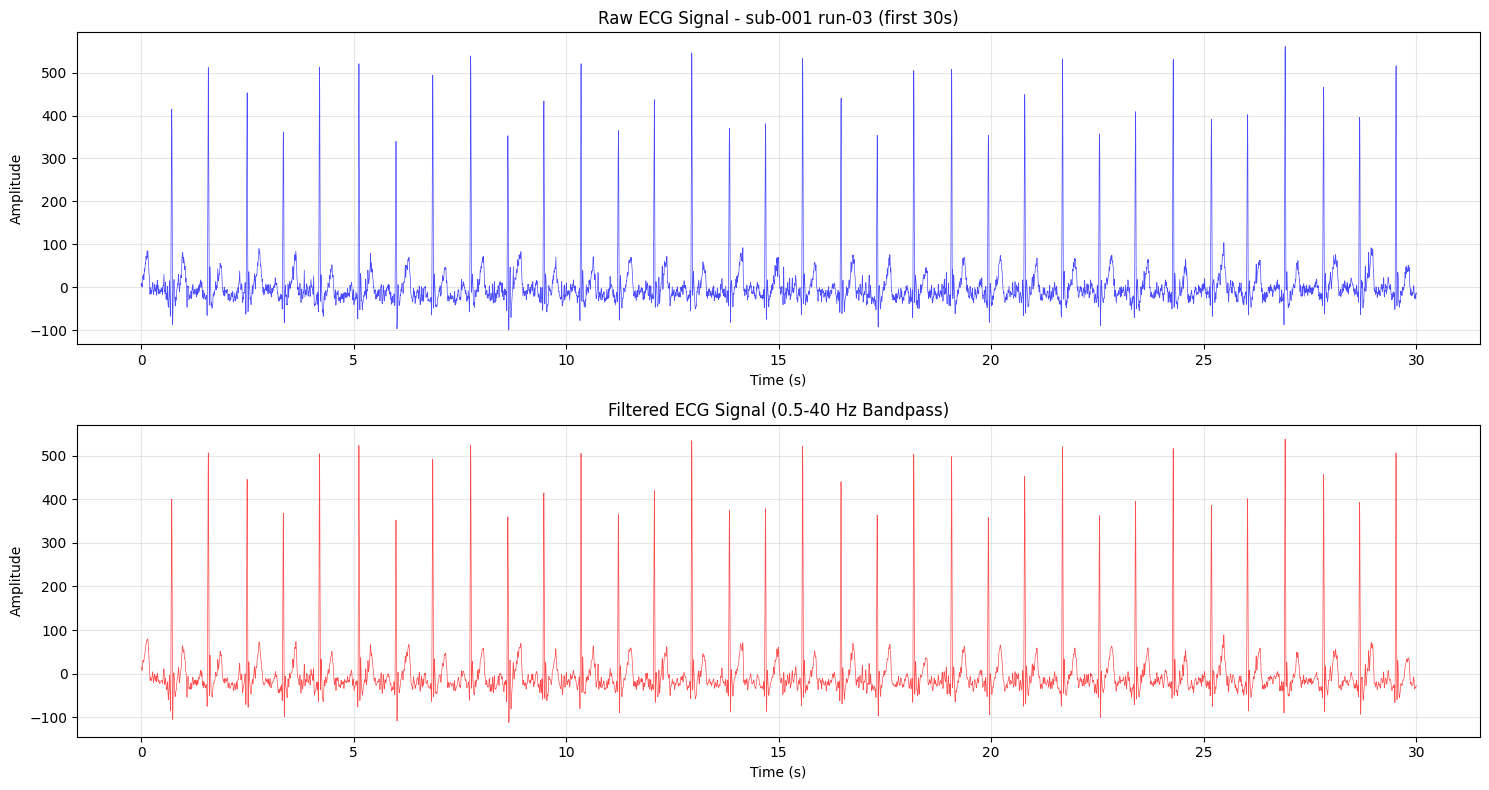

Preprocessing Summary:
  Signal duration: 7200.0 seconds
  Sampling rate: 256 Hz
  Filter: 0.5-40 Hz bandpass
  Processing time: 0.03 seconds
  Artifact reduction: 1.05% → 1.24%


In [7]:
if raw_ecg is not None and filtered_ecg is not None:
    # Plot first 30 seconds for comparison
    plot_duration = 30  # seconds
    plot_samples = min(plot_duration * FS, len(raw_ecg))
    time_axis = np.linspace(0, plot_samples/FS, plot_samples)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    
    # Raw ECG
    ax1.plot(time_axis, raw_ecg[:plot_samples], 'b-', linewidth=0.5, alpha=0.7)
    ax1.set_title(f'Raw ECG Signal - {metadata["patient_id"]} {metadata["run_id"]} (first {plot_duration}s)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.grid(True, alpha=0.3)
    
    # Filtered ECG
    ax2.plot(time_axis, filtered_ecg[:plot_samples], 'r-', linewidth=0.5, alpha=0.7)
    ax2.set_title(f'Filtered ECG Signal (0.5-40 Hz Bandpass)')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Amplitude')
    ax2.grid(True, alpha=0.3)
    
    # Mark seizures if any occur in this window
    for seizure in metadata['seizures_in_window']:
        if seizure['start'] < plot_duration:
            seizure_end = min(seizure['end'], plot_duration)
            ax1.axvspan(seizure['start'], seizure_end, alpha=0.3, color='red', label='Seizure')
            ax2.axvspan(seizure['start'], seizure_end, alpha=0.3, color='red', label='Seizure')
    
    if metadata['seizures_in_window']:
        ax1.legend()
        ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Preprocessing Summary:")
    print(f"  Signal duration: {metadata['duration_sec']:.1f} seconds")
    print(f"  Sampling rate: {FS} Hz")
    print(f"  Filter: 0.5-40 Hz bandpass")
    print(f"  Processing time: {preprocessing_results['preprocessing_time']:.2f} seconds")
    print(f"  Artifact reduction: {raw_quality['artifact_percentage']:.2f}% → {filtered_quality['artifact_percentage']:.2f}%")

## 8. MERLIN Anomaly Detection

In [ ]:
def run_merlin_experiment(ecg_signal, config, fs=256):
    """
    Run MERLIN with specific configuration
    
    Args:
        ecg_signal (np.array): Preprocessed ECG signal
        config (dict): MERLIN configuration
        fs (int): Sampling frequency
    
    Returns:
        dict: Results including anomalies, timing, and metadata
    """
    print(f"\nRunning MERLIN with config: {config['name']}")
    print(f"  Window range: {config['min_length']}-{config['max_length']} samples")
    print(f"  Time range: {config['min_length']/fs:.1f}-{config['max_length']/fs:.1f} seconds")
    
    # Initialize MERLIN detector
    detector = MERLIN(
        min_length=config['min_length'],
        max_length=config['max_length'],
        max_iterations=500
    )
    
    # Run detection
    start_time = time.time()
    anomalies = detector.fit_predict(ecg_signal)
    detection_time = time.time() - start_time
    
    # Calculate detection statistics
    n_anomalies = np.sum(anomalies)
    anomaly_rate = n_anomalies / len(ecg_signal) * 100
    
    # Find anomaly regions (consecutive anomaly points)
    anomaly_regions = []
    if n_anomalies > 0:
        anomaly_indices = np.where(anomalies)[0]
        
        # Group consecutive indices into regions
        if len(anomaly_indices) > 0:
            region_start = anomaly_indices[0]
            region_end = anomaly_indices[0]
            
            for i in range(1, len(anomaly_indices)):
                if anomaly_indices[i] == region_end + 1:
                    # Consecutive, extend current region
                    region_end = anomaly_indices[i]
                else:
                    # Gap found, close current region and start new one
                    anomaly_regions.append({
                        'start_sample': region_start,
                        'end_sample': region_end,
                        'start_time': region_start / fs,
                        'end_time': region_end / fs,
                        'duration': (region_end - region_start + 1) / fs
                    })
                    region_start = anomaly_indices[i]
                    region_end = anomaly_indices[i]
            
            # Don't forget the last region
            anomaly_regions.append({
                'start_sample': region_start,
                'end_sample': region_end,
                'start_time': region_start / fs,
                'end_time': region_end / fs,
                'duration': (region_end - region_start + 1) / fs
            })
    
    results = {
        'config': config,
        'anomalies': anomalies,
        'n_anomalies': n_anomalies,
        'anomaly_rate': anomaly_rate,
        'anomaly_regions': anomaly_regions,
        'detection_time': detection_time,
        'samples_per_second': len(ecg_signal) / detection_time
    }
    
    print(f"  ✓ Detection completed in {detection_time:.2f} seconds")
    print(f"  ✓ Found {n_anomalies:,} anomaly points ({anomaly_rate:.3f}% of signal)")
    print(f"  ✓ Found {len(anomaly_regions)} anomaly regions")
    print(f"  ✓ Processing speed: {results['samples_per_second']:.1f} samples/second")
    
    return results

# Run MERLIN experiments with different configurations
if filtered_ecg is not None:
    merlin_results = []
    
    print(f"\n{'='*60}")
    print(f"MERLIN ANOMALY DETECTION EXPERIMENTS")
    print(f"{'='*60}")
    print(f"Signal: {len(filtered_ecg):,} samples ({len(filtered_ecg)/FS:.1f} seconds)")
    print(f"Configurations: {len(MERLIN_CONFIGS)}")
    
    for i, config in enumerate(MERLIN_CONFIGS):
        print(f"\n[{i+1}/{len(MERLIN_CONFIGS)}] Testing configuration: {config['name']}")
        
        try:
            short_signal = filtered_ecg[:300]  # z. B. nur die ersten 100 Samples
            result = run_merlin_experiment(short_signal, config, FS) #short_signal zu filtered_ecg wieder ändern!
            merlin_results.append(result)
        except Exception as e:
            print(f"  ❌ Error with config {config['name']}: {e}")
            continue
    
    print(f"\n✓ Completed {len(merlin_results)}/{len(MERLIN_CONFIGS)} experiments")
    
else:
    print("❌ No filtered ECG data available for MERLIN experiment")
    merlin_results = []


MERLIN ANOMALY DETECTION EXPERIMENTS
Signal: 1,843,200 samples (7200.0 seconds)
Configurations: 1

[1/1] Testing configuration: 1-10sec

Running MERLIN with config: 1-10sec
  Window range: 256-2560 samples
  Time range: 1.0-10.0 seconds
  ❌ Error with config 1-10sec: Series length of X 100 is less than min_length 256

✓ Completed 0/1 experiments


## 9. Results Summary and Comparison

In [9]:
if merlin_results:
    print(f"\n{'='*80}")
    print(f"MERLIN EXPERIMENT RESULTS SUMMARY")
    print(f"{'='*80}")
    print(f"Patient: {metadata['patient_id']} {metadata['run_id']}")
    print(f"Duration: {metadata['duration_sec']:.1f} seconds ({metadata['duration_sec']/3600:.1f} hours)")
    print(f"True seizures in window: {len(metadata['seizures_in_window'])}")
    print(f"\nConfiguration Comparison:")
    print(f"{'Config':<10} | {'Window':<12} | {'Anomalies':<10} | {'Rate %':<8} | {'Regions':<8} | {'Time (s)':<8} | {'Speed':<12}")
    print("-" * 80)
    
    for result in merlin_results:
        config = result['config']
        window_str = f"{config['min_length']}-{config['max_length']}"
        speed_str = f"{result['samples_per_second']:.0f} smp/s"
        
        print(f"{config['name']:<10} | {window_str:<12} | {result['n_anomalies']:<10,} | "
              f"{result['anomaly_rate']:<8.3f} | {len(result['anomaly_regions']):<8} | "
              f"{result['detection_time']:<8.2f} | {speed_str:<12}")
    
    # Find best configuration (most anomaly regions, assuming more regions = better seizure detection)
    best_result = max(merlin_results, key=lambda r: len(r['anomaly_regions']))
    print(f"\nBest configuration (most anomaly regions): {best_result['config']['name']}")
    print(f"  Anomaly regions: {len(best_result['anomaly_regions'])}")
    print(f"  Total anomaly points: {best_result['n_anomalies']:,}")
    print(f"  Detection time: {best_result['detection_time']:.2f} seconds")
    
    # Show anomaly regions for best configuration
    if best_result['anomaly_regions']:
        print(f"\nDetected Anomaly Regions ({best_result['config']['name']}):")
        for i, region in enumerate(best_result['anomaly_regions'][:10]):  # Show first 10
            print(f"  {i+1:2d}. {region['start_time']:7.1f}s - {region['end_time']:7.1f}s "
                  f"(duration: {region['duration']:5.2f}s)")
        
        if len(best_result['anomaly_regions']) > 10:
            print(f"  ... and {len(best_result['anomaly_regions']) - 10} more regions")
    
else:
    print("❌ No MERLIN results available")

❌ No MERLIN results available


## 10. Evaluation Against Ground Truth Seizures

In [10]:
def evaluate_anomaly_detection(anomaly_regions, true_seizures, tolerance_sec=5.0):
    """
    Evaluate anomaly detection against ground truth seizures
    
    Args:
        anomaly_regions (list): Detected anomaly regions
        true_seizures (list): Ground truth seizures
        tolerance_sec (float): Tolerance for matching in seconds
    
    Returns:
        dict: Evaluation metrics
    """
    if not true_seizures:
        return {
            'true_positives': 0,
            'false_positives': len(anomaly_regions),
            'false_negatives': 0,
            'sensitivity': 0.0,
            'precision': 0.0,
            'f1_score': 0.0,
            'false_alarm_rate_per_hour': 0.0
        }
    
    # Match anomaly regions to seizures
    detected_seizures = set()
    matched_anomalies = set()
    
    for i, seizure in enumerate(true_seizures):
        seizure_start = seizure['start']
        seizure_end = seizure['end']
        
        for j, anomaly in enumerate(anomaly_regions):
            anomaly_start = anomaly['start_time']
            anomaly_end = anomaly['end_time']
            
            # Check for overlap within tolerance
            if (anomaly_start <= seizure_end + tolerance_sec and 
                anomaly_end >= seizure_start - tolerance_sec):
                detected_seizures.add(i)
                matched_anomalies.add(j)
                break  # One anomaly per seizure
    
    # Calculate metrics
    true_positives = len(detected_seizures)
    false_negatives = len(true_seizures) - true_positives
    false_positives = len(anomaly_regions) - len(matched_anomalies)
    
    sensitivity = true_positives / len(true_seizures) if true_seizures else 0.0
    precision = true_positives / len(anomaly_regions) if anomaly_regions else 0.0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0.0
    
    # False alarm rate per hour
    experiment_hours = metadata['duration_sec'] / 3600
    false_alarm_rate_per_hour = false_positives / experiment_hours
    
    return {
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'sensitivity': sensitivity,
        'precision': precision,
        'f1_score': f1_score,
        'false_alarm_rate_per_hour': false_alarm_rate_per_hour,
        'detected_seizures': detected_seizures,
        'matched_anomalies': matched_anomalies
    }

# Evaluate all MERLIN configurations
if merlin_results and metadata['seizures_in_window']:
    print(f"\n{'='*80}")
    print(f"EVALUATION AGAINST GROUND TRUTH SEIZURES")
    print(f"{'='*80}")
    print(f"Ground truth seizures: {len(metadata['seizures_in_window'])}")
    print(f"Tolerance for matching: 5.0 seconds")
    print(f"\nEvaluation Results:")
    print(f"{'Config':<10} | {'TP':<3} | {'FP':<3} | {'FN':<3} | {'Sens':<6} | {'Prec':<6} | {'F1':<6} | {'FAR/h':<6}")
    print("-" * 70)
    
    evaluation_results = []
    
    for result in merlin_results:
        eval_metrics = evaluate_anomaly_detection(
            result['anomaly_regions'], 
            metadata['seizures_in_window']
        )
        
        evaluation_results.append({
            'config': result['config']['name'],
            'metrics': eval_metrics
        })
        
        print(f"{result['config']['name']:<10} | {eval_metrics['true_positives']:<3} | "
              f"{eval_metrics['false_positives']:<3} | {eval_metrics['false_negatives']:<3} | "
              f"{eval_metrics['sensitivity']:<6.2f} | {eval_metrics['precision']:<6.2f} | "
              f"{eval_metrics['f1_score']:<6.2f} | {eval_metrics['false_alarm_rate_per_hour']:<6.1f}")
    
    # Find best configuration by F1 score
    best_eval = max(evaluation_results, key=lambda r: r['metrics']['f1_score'])
    print(f"\nBest configuration by F1 score: {best_eval['config']}")
    print(f"  Sensitivity: {best_eval['metrics']['sensitivity']:.3f}")
    print(f"  Precision: {best_eval['metrics']['precision']:.3f}")
    print(f"  F1 Score: {best_eval['metrics']['f1_score']:.3f}")
    print(f"  False Alarm Rate: {best_eval['metrics']['false_alarm_rate_per_hour']:.1f} per hour")
    
elif merlin_results:
    print(f"\n⚠️  No ground truth seizures available for evaluation")
    print(f"Detected anomaly regions across all configurations:")
    for result in merlin_results:
        print(f"  {result['config']['name']}: {len(result['anomaly_regions'])} regions")
    
else:
    print(f"\n❌ No results available for evaluation")


❌ No results available for evaluation


## 11. Visualization: MERLIN Results

In [11]:
def plot_merlin_results(ecg_signal, merlin_result, metadata, plot_duration=300, fs=256):
    """
    Plot ECG signal with MERLIN anomaly detection results
    
    Args:
        ecg_signal (np.array): Preprocessed ECG signal
        merlin_result (dict): MERLIN detection results
        metadata (dict): Experiment metadata
        plot_duration (int): Duration to plot in seconds
        fs (int): Sampling frequency
    """
    # Prepare data for plotting
    plot_samples = min(plot_duration * fs, len(ecg_signal))
    plot_time = np.linspace(0, plot_samples/fs, plot_samples)
    plot_ecg = ecg_signal[:plot_samples]
    plot_anomalies = merlin_result['anomalies'][:plot_samples]
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: ECG with anomaly highlighting
    ax1.plot(plot_time, plot_ecg, 'b-', linewidth=0.5, alpha=0.8, label='ECG Signal')
    
    # Highlight anomaly points
    if np.any(plot_anomalies):
        anomaly_times = plot_time[plot_anomalies]
        anomaly_values = plot_ecg[plot_anomalies]
        ax1.scatter(anomaly_times, anomaly_values, c='red', s=1, alpha=0.8, label='MERLIN Anomalies')
    
    # Mark ground truth seizures
    for i, seizure in enumerate(metadata['seizures_in_window']):
        if seizure['start'] < plot_duration:
            seizure_end = min(seizure['end'], plot_duration)
            ax1.axvspan(seizure['start'], seizure_end, alpha=0.3, color='orange', 
                       label='True Seizure' if i == 0 else "")
    
    ax1.set_title(f'ECG Signal with MERLIN Anomaly Detection - {merlin_result["config"]["name"]} Configuration')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Anomaly regions as bars
    ax2.set_ylim(-0.5, 1.5)
    
    # Plot anomaly regions
    for region in merlin_result['anomaly_regions']:
        if region['start_time'] < plot_duration:
            region_end = min(region['end_time'], plot_duration)
            ax2.barh(0, region_end - region['start_time'], left=region['start_time'], 
                    height=0.3, color='red', alpha=0.7, label='Detected Anomaly' if region == merlin_result['anomaly_regions'][0] else "")
    
    # Plot true seizures
    for i, seizure in enumerate(metadata['seizures_in_window']):
        if seizure['start'] < plot_duration:
            seizure_end = min(seizure['end'], plot_duration)
            ax2.barh(1, seizure_end - seizure['start'], left=seizure['start'], 
                    height=0.3, color='orange', alpha=0.7, label='True Seizure' if i == 0 else "")
    
    ax2.set_xlim(0, plot_duration)
    ax2.set_yticks([0, 1])
    ax2.set_yticklabels(['MERLIN\nAnomalies', 'True\nSeizures'])
    ax2.set_xlabel('Time (s)')
    ax2.set_title('Timeline Comparison: MERLIN Anomalies vs True Seizures')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print region details
    print(f"\nRegion Details for {merlin_result['config']['name']} (first {plot_duration}s):")
    regions_in_plot = [r for r in merlin_result['anomaly_regions'] if r['start_time'] < plot_duration]
    print(f"  MERLIN Anomaly Regions: {len(regions_in_plot)}")
    for i, region in enumerate(regions_in_plot[:5]):  # Show first 5
        print(f"    {i+1}. {region['start_time']:6.1f}s - {region['end_time']:6.1f}s (duration: {region['duration']:5.2f}s)")
    
    seizures_in_plot = [s for s in metadata['seizures_in_window'] if s['start'] < plot_duration]
    print(f"  True Seizures: {len(seizures_in_plot)}")
    for i, seizure in enumerate(seizures_in_plot):
        print(f"    {i+1}. {seizure['start']:6.1f}s - {seizure['end']:6.1f}s (duration: {seizure['duration']:5.2f}s, type: {seizure['type']})")

# Plot results for best configuration
if merlin_results and filtered_ecg is not None:
    print(f"\n{'='*60}")
    print(f"VISUALIZATION: MERLIN DETECTION RESULTS")
    print(f"{'='*60}")
    
    # Plot best configuration (by number of anomaly regions)
    best_result = max(merlin_results, key=lambda r: len(r['anomaly_regions']))
    
    print(f"Plotting results for best configuration: {best_result['config']['name']}")
    plot_merlin_results(filtered_ecg, best_result, metadata, plot_duration=600, fs=FS)
    
    # If there are multiple results, also plot a comparison
    if len(merlin_results) > 1:
        print(f"\nConfiguration Comparison (first 300 seconds):")
        
        fig, axes = plt.subplots(len(merlin_results), 1, figsize=(15, 3 * len(merlin_results)))
        if len(merlin_results) == 1:
            axes = [axes]
        
        plot_duration = 300  # 5 minutes
        plot_samples = min(plot_duration * FS, len(filtered_ecg))
        plot_time = np.linspace(0, plot_samples/FS, plot_samples)
        
        for i, result in enumerate(merlin_results):
            # Plot anomaly regions as horizontal bars
            for region in result['anomaly_regions']:
                if region['start_time'] < plot_duration:
                    region_end = min(region['end_time'], plot_duration)
                    axes[i].barh(0, region_end - region['start_time'], left=region['start_time'], 
                               height=0.5, color='red', alpha=0.7)
            
            # Mark true seizures
            for seizure in metadata['seizures_in_window']:
                if seizure['start'] < plot_duration:
                    seizure_end = min(seizure['end'], plot_duration)
                    axes[i].axvspan(seizure['start'], seizure_end, alpha=0.3, color='orange')
            
            axes[i].set_xlim(0, plot_duration)
            axes[i].set_ylim(-0.25, 0.75)
            axes[i].set_title(f'{result["config"]["name"]} - {len(result["anomaly_regions"])} regions')
            axes[i].set_ylabel('Anomalies')
            axes[i].grid(True, alpha=0.3)
            
            if i == len(merlin_results) - 1:
                axes[i].set_xlabel('Time (s)')
        
        plt.tight_layout()
        plt.show()

else:
    print("❌ No results available for visualization")

❌ No results available for visualization


## 12. Experiment Summary and Conclusions

In [12]:
print(f"\n{'='*80}")
print(f"MERLIN ECG SEIZURE DETECTION EXPERIMENT SUMMARY")
print(f"{'='*80}")

# Patient and data summary
if 'metadata' in locals() and metadata:
    print(f"\nPatient Information:")
    print(f"  Patient ID: {metadata['patient_id']}")
    print(f"  Run ID: {metadata['run_id']}")
    print(f"  Duration: {metadata['duration_sec']:.1f} seconds ({metadata['duration_sec']/3600:.1f} hours)")
    print(f"  Sampling Rate: {metadata['fs']} Hz")
    print(f"  Total Samples: {metadata['total_samples']:,}")
    print(f"  True Seizures: {len(metadata['seizures_in_window'])}")

# Signal quality summary
if 'preprocessing_results' in locals():
    print(f"\nSignal Quality:")
    print(f"  Raw Signal Quality: {preprocessing_results['raw_quality']['quality']}")
    print(f"  Filtered Signal Quality: {preprocessing_results['filtered_quality']['quality']}")
    print(f"  Artifact Reduction: {preprocessing_results['raw_quality']['artifact_percentage']:.2f}% → {preprocessing_results['filtered_quality']['artifact_percentage']:.2f}%")
    print(f"  Preprocessing Time: {preprocessing_results['preprocessing_time']:.2f} seconds")

# MERLIN results summary
if 'merlin_results' in locals() and merlin_results:
    print(f"\nMERLIN Configuration Performance:")
    
    for result in merlin_results:
        config = result['config']
        print(f"  {config['name']}:")
        print(f"    Window: {config['min_length']}-{config['max_length']} samples ({config['min_length']/FS:.1f}-{config['max_length']/FS:.1f}s)")
        print(f"    Anomaly Points: {result['n_anomalies']:,} ({result['anomaly_rate']:.3f}%)")
        print(f"    Anomaly Regions: {len(result['anomaly_regions'])}")
        print(f"    Detection Time: {result['detection_time']:.2f}s")
        print(f"    Processing Speed: {result['samples_per_second']:.0f} samples/second")
    
    # Best configuration
    best_result = max(merlin_results, key=lambda r: len(r['anomaly_regions']))
    print(f"\nBest Configuration (most regions): {best_result['config']['name']}")

# Evaluation summary
if 'evaluation_results' in locals() and evaluation_results:
    print(f"\nEvaluation Results:")
    best_f1 = max(evaluation_results, key=lambda r: r['metrics']['f1_score'])
    
    print(f"  Best F1 Score: {best_f1['config']} (F1: {best_f1['metrics']['f1_score']:.3f})")
    print(f"    Sensitivity: {best_f1['metrics']['sensitivity']:.3f}")
    print(f"    Precision: {best_f1['metrics']['precision']:.3f}")
    print(f"    False Alarm Rate: {best_f1['metrics']['false_alarm_rate_per_hour']:.1f} per hour")
    
    # Overall performance assessment
    avg_sensitivity = np.mean([r['metrics']['sensitivity'] for r in evaluation_results])
    avg_precision = np.mean([r['metrics']['precision'] for r in evaluation_results])
    avg_f1 = np.mean([r['metrics']['f1_score'] for r in evaluation_results])
    
    print(f"\n  Average Performance Across Configurations:")
    print(f"    Sensitivity: {avg_sensitivity:.3f}")
    print(f"    Precision: {avg_precision:.3f}")
    print(f"    F1 Score: {avg_f1:.3f}")

# Conclusions and recommendations
print(f"\nConclusions:")

if 'merlin_results' in locals() and merlin_results:
    total_regions = sum(len(r['anomaly_regions']) for r in merlin_results)
    avg_regions = total_regions / len(merlin_results)
    
    print(f"  ✓ MERLIN successfully applied to {len(filtered_ecg):,} ECG samples")
    print(f"  ✓ Tested {len(merlin_results)} different window configurations")
    print(f"  ✓ Average anomaly regions per configuration: {avg_regions:.1f}")
    
    if 'evaluation_results' in locals() and evaluation_results:
        if any(r['metrics']['sensitivity'] > 0 for r in evaluation_results):
            print(f"  ✓ Successfully detected seizure events with MERLIN")
        else:
            print(f"  ⚠️  No seizures detected - may need parameter tuning")
    
    # Performance assessment
    avg_speed = np.mean([r['samples_per_second'] for r in merlin_results])
    if avg_speed > FS:  # Real-time capable
        print(f"  ✓ Real-time capable (avg: {avg_speed:.0f} samples/s > {FS} Hz)")
    else:
        print(f"  ⚠️  Not real-time capable (avg: {avg_speed:.0f} samples/s < {FS} Hz)")

else:
    print(f"  ❌ MERLIN experiments failed - check data and dependencies")

print(f"\nRecommendations for Future Work:")
print(f"  1. Test with more patients to validate generalization")
print(f"  2. Optimize MERLIN parameters (max_iterations, distance thresholds)")
print(f"  3. Compare with other anomaly detection algorithms")
print(f"  4. Implement real-time processing optimizations")
print(f"  5. Explore feature engineering (heart rate, HRV) for improved detection")

print(f"\n{'='*80}")
print(f"EXPERIMENT COMPLETED")
print(f"{'='*80}")


MERLIN ECG SEIZURE DETECTION EXPERIMENT SUMMARY

Patient Information:
  Patient ID: sub-001
  Run ID: run-03
  Duration: 7200.0 seconds (2.0 hours)
  Sampling Rate: 256.0 Hz
  Total Samples: 1,843,200
  True Seizures: 0

Signal Quality:
  Raw Signal Quality: good
  Filtered Signal Quality: good
  Artifact Reduction: 1.05% → 1.24%
  Preprocessing Time: 0.03 seconds

Conclusions:
  ❌ MERLIN experiments failed - check data and dependencies

Recommendations for Future Work:
  1. Test with more patients to validate generalization
  2. Optimize MERLIN parameters (max_iterations, distance thresholds)
  3. Compare with other anomaly detection algorithms
  4. Implement real-time processing optimizations
  5. Explore feature engineering (heart rate, HRV) for improved detection

EXPERIMENT COMPLETED


## 13. Export Results (Optional)

In [13]:
# Optional: Save results to file
import json
from datetime import datetime

def export_results(metadata, merlin_results, evaluation_results=None, filename=None):
    """
    Export experiment results to JSON file
    """
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"../results/merlin_experiment_{metadata['patient_id']}_{metadata['run_id']}_{timestamp}.json"
    
    # Prepare results for JSON serialization
    export_data = {
        'experiment_info': {
            'timestamp': datetime.now().isoformat(),
            'patient_id': metadata['patient_id'],
            'run_id': metadata['run_id'],
            'duration_sec': metadata['duration_sec'],
            'sampling_rate': metadata['fs'],
            'total_samples': metadata['total_samples'],
            'true_seizures': len(metadata['seizures_in_window'])
        },
        'seizures': metadata['seizures_in_window'],
        'merlin_configs': [r['config'] for r in merlin_results],
        'detection_results': [
            {
                'config': r['config'],
                'n_anomalies': r['n_anomalies'],
                'anomaly_rate': r['anomaly_rate'],
                'n_regions': len(r['anomaly_regions']),
                'detection_time': r['detection_time'],
                'processing_speed': r['samples_per_second'],
                'anomaly_regions': r['anomaly_regions']
            }
            for r in merlin_results
        ]
    }
    
    if evaluation_results:
        export_data['evaluation_results'] = evaluation_results
    
    # Create results directory if it doesn't exist
    results_dir = Path(filename).parent
    results_dir.mkdir(exist_ok=True)
    
    # Save to file
    with open(filename, 'w') as f:
        json.dump(export_data, f, indent=2)
    
    print(f"Results exported to: {filename}")
    return filename

# Export results if available
if 'metadata' in locals() and 'merlin_results' in locals() and merlin_results:
    eval_results = evaluation_results if 'evaluation_results' in locals() else None
    export_filename = export_results(metadata, merlin_results, eval_results)
    print(f"\n✓ Experiment results saved for future analysis")
else:
    print(f"\n⚠️  No results available to export")


⚠️  No results available to export
